# Demonstrats the output of Smica propagation code

In [115]:
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import json
import component_separation
import component_separation.io as io
import healpy as hp
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw
import component_separation.preprocess as prep
from component_separation.cs_util import Config as csu
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
import matplotlib.pyplot as plt
with open(os.path.dirname(component_separation.__file__)+'/config.json', "r") as f:
    cf = json.load(f)
    
import platform
uname = platform.uname()
if uname.node == "DESKTOP-KMIGUPV":
    mch = "XPS"
else:
    mch = "NERSC"
    
CMB = dict()
almT, almE, almB = dict(), dict(), dict()

In [117]:
data = io.load_plamap(cf, field=(0,1,2))
lmax = 1500
names = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
nside = 512
smica_W_pol = np.loadtxt("/global/homes/s/sebibel/data/weights/weights_EB_smica_R3.00.txt").reshape(2,7,4001)
smica_W_t = np.loadtxt("/global/homes/s/sebibel/data/weights/weights_T_smica_R3.00_Xfull.txt")
# data = prep.preprocess_all(data)

ndet=7
D_lS = pd.read_csv(
        cf[mch]['powspec_truthfile'],
        header=0,
        sep='    ',
        index_col=0)
D_lS_EE = D_lS["Planck-"+"EE"].to_numpy()
C_lS_EE = D_lS_EE[:lmax+1]/hpf.llp1e12(np.array([range(lmax+1)]))
cov_lS_EE = np.ones((ndet,ndet,lmax+1)) * C_lS_EE * 1e12

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/

loaded {'030': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_030_map.fits', '044': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_044_map.fits', '070': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_070_map.fits', '100': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_100_map.fits', '143': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_143_map.fits', '217': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_217_map.fits', '353': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_353_map.fits'}


<ipython-input-117-782b7c7c58e6>:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  D_lS = pd.read_csv(
<ipython-input-117-782b7c7c58e6>:16: RuntimeWarning: invalid value encountered in true_divide
  C_lS_EE = D_lS_EE[:lmax+1]/hpf.llp1e12(np.array([range(lmax+1)]))


In [118]:
for name in names[:-2]:
    alms = hp.map2alm(hp.ud_grade(data[name], nside_out=nside), lmax, iter=0) # full sky QU->EB
    almT[name] = alms[0]
    almE[name] = alms[1]
    almB[name] = alms[2]

In [119]:
nalm = int((lmax+1)*(lmax+2)/2)  
combalmT = np.zeros((nalm), dtype=np.complex128)
combalmE = np.zeros((nalm), dtype=np.complex128)
combalmB = np.zeros((nalm), dtype=np.complex128)
for m,name in zip(range(len(names[:-2])),names[:-2]):
    combalmT += hp.almxfl(almT[name], np.squeeze(smica_W_t[m,:]))
    combalmE += hp.almxfl(almE[name], np.squeeze(smica_W_pol[0,m,:]))
    combalmB += hp.almxfl(almB[name], np.squeeze(smica_W_pol[1,m,:]))

0 030
1 044
2 070
3 100
4 143
5 217
6 353


In [121]:
CMB["TT"] = hp.almxfl(combalmT, hp.pixwin(nside)[0:lmax])
CMB["EE"] = hp.almxfl(combalmE, hp.pixwin(nside, pol=True)[0][0:lmax])
CMB["BB"] = hp.almxfl(combalmB, hp.pixwin(nside, pol=True)[1][0:lmax])

CMB["TQU"] = hp.alm2map([CMB["TT"], CMB["EE"], CMB["BB"]], nside)

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [143]:
cl = hp.anafast(CMB["TQU"])

# Final step of Smica propagation code
Blue shows the sum over all detector alms, multiplied with the respective weights. This should be somewhat identical to the minimum variance way (at least for highish ell)

Text(0, 0.5, 'powerspectrum C_l')

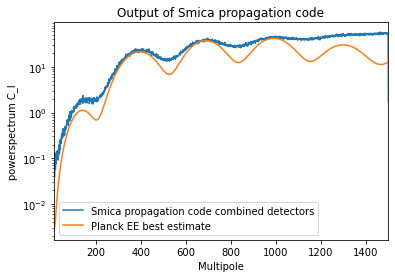

In [203]:
for n in [1]:#range(1):
    plt.plot(cl[n,:]*hpf.llp1e12(np.array(range(1536))), label='Smica propagation code combined detectors')
plt.plot(D_lS_EE, label= "Planck EE best estimate")
plt.yscale('log')
plt.legend()
plt.title("Output of Smica propagation code")
# plt.ylim((1e-16,1e-14))
plt.xlim((10,1500))
plt.xlabel('Multipole')
plt.ylabel('powerspectrum C_l')